# Univariate and Bivariate Von Mises distributions implemented in Numpyro

In [1]:
import jax
import jax.numpy as np
import jax.random as random
from jax.scipy.special import gammaln, logsumexp
from jax import jit, lax
from numpyro.distributions import constraints 
from numpyro.distributions.distribution import Distribution 
from numpyro.util import copy_docs_from
from functools import partial
from numpyro.distributions.util import lazy_property, promote_shapes, validate_sample
import time
import warnings

"""The implementation of the univariate Von Mises distribution follows the implementation of the same
distribution in Pytorch torch.distributions package. The original code for the Pytorch implementation can be 
found athttps://pytorch.org/docs/stable/_modules/torch/distributions/von_mises.html#VonMises"""

_I0_COEF_SMALL = np.array([1.0, 3.5156229, 3.0899424, 1.2067492, 0.2659732, 0.360768e-1, 0.45813e-2])
_I0_COEF_LARGE = np.array([0.39894228, 0.1328592e-1, 0.225319e-2, -0.157565e-2, 0.916281e-2,
                  -0.2057706e-1, 0.2635537e-1, -0.1647633e-1, 0.392377e-2])
_I1_COEF_SMALL = np.array([0.5, 0.87890594, 0.51498869, 0.15084934, 0.2658733e-1, 0.301532e-2, 0.32411e-3])
_I1_COEF_LARGE = np.array([0.39894228, -0.3988024e-1, -0.362018e-2, 0.163801e-2, -0.1031555e-1,
                  0.2282967e-1, -0.2895312e-1, 0.1787654e-1, -0.420059e-2])

@jit
def _log_modified_bessel_fn(x, order):
    """
    Returns ``log(I_order(x))`` for ``x > 0``,
    where `order` is either 0 or 1.
    
    Based on https://pytorch.org/docs/stable/_modules/torch/distributions/von_mises.html#VonMises
    """
    # compute small solution
    y = (x / 3.75)
    y = y * y
    
    COEF_SMALL = np.where(np.ones((7,))*order, _I1_COEF_SMALL, _I0_COEF_SMALL)
    COEF_LARGE = np.where(np.ones((9,))*order, _I1_COEF_LARGE, _I0_COEF_LARGE)
    
    small = _eval_poly_small(y, COEF_SMALL)
    small = np.where(np.ones(x.shape)*order, abs(x) * small, small)
    small = np.log(small)

    # compute large solution
    y = 3.75 / x
    large = x - 0.5 * np.log(x) + np.log(_eval_poly_large(y, COEF_LARGE))

    result = np.where(x < 3.75, small, large)
    return result

@jit
def _eval_poly_small(y, coef):
    return coef[-7] + y*(coef[-6] + y*(coef[-5] + y*(coef[-4] + y*(coef[-3] + y*(coef[-2] + y*coef[-1])))))

@jit
def _eval_poly_large(y, coef):
    return coef[-9] + y*(coef[-8] + y*(coef[-7] + y*( coef[-6] + 
                        y*(coef[-5] + y*(coef[-4] + y*(coef[-3] + y*(coef[-2] + y*coef[-1])))))))

def condition(args):
    return ~np.all(args[2])

def loop(args):
    x, proposal_r, done, key, concentration = args
    key, subkey = jax.random.split(key)
    u = jax.random.uniform(subkey, shape = (3,) + x.shape)
    u1, u2, u3 = u.squeeze()
    z = np.cos(np.pi * u1)
    f = (1 + proposal_r * z) / (proposal_r + z)
    c = concentration * (proposal_r - f)
    accept = ((c * (2 - c) - u2) > 0) | (np.log(c / u2) + 1 - c >= 0)
    x = np.where(accept, np.sign(u3 - 0.5) * np.arccos(f),  x)          
    done = done | accept
    return x, proposal_r, done, key, concentration

@jit
def _rejection_sample(loc, concentration, proposal_r, key, x):
    """
    Acceptance-rejection sampling method – translated from the Pytorch univariate von Mises implementation. 
    
    The sampling algorithm for the von Mises distribution is based on the following paper:
    Best, D. J., and Nicholas I. Fisher.
    "Efficient simulation of the von Mises distribution." Applied Statistics (1979): 152-157.
    """
    done = np.zeros(x.shape, dtype=bool)
    x = lax.while_loop(condition, loop, (x, proposal_r, done, key, concentration))[0]
    return (x + np.pi + loc) % (2 * np.pi) - np.pi
    
@copy_docs_from(Distribution)
class VonMises(Distribution):
    """
    A circular von Mises distribution.

    This implementation uses polar coordinates. The ``loc`` and ``value`` args
    can be any real number (to facilitate unconstrained optimization), but are
    interpreted as angles modulo 2 pi.

    :param int or ndarray: an angle in radians.
    :param int ord ndarray: concentration parameter
    
    Based on https://pytorch.org/docs/stable/_modules/torch/distributions/von_mises.html#VonMises
    """
    arg_constraints = {'loc': constraints.real, 'concentration': constraints.positive}
    support = constraints.real
    has_rsample = False
    
    def __repr__(self):
        return str(type(self).__name__) + "(loc: " + str(self.loc) + ", concentration: " + str(self.concentration) + ")"

    def __init__(self, loc, concentration, validate_args=None):
        self.loc, self.concentration = promote_shapes(loc, concentration)
        batch_shape = lax.broadcast_shapes(np.shape(loc), np.shape(concentration))
        event_shape = ()
        tau = 1 + np.sqrt(1 + 4 * self.concentration ** 2)
        rho = (tau - np.sqrt(2 * tau)) / (2 * self.concentration)
        self._proposal_r = (1 + rho ** 2) / (2 * rho)
        super(VonMises, self).__init__(batch_shape, event_shape, validate_args)

    def log_prob(self, value):
        log_prob = self.concentration * np.cos(value - self.loc)
        log_prob = log_prob - np.log(2 * np.pi) - _log_modified_bessel_fn(self.concentration, 0)
        return log_prob.T
    
    def sample(self, key, sample_shape = ()):
        """
        The sampling algorithm for the von Mises distribution is based on the following paper:
        Best, D. J., and Nicholas I. Fisher.
        "Efficient simulation of the von Mises distribution." Applied Statistics (1979): 152-157.
        
        Based on https://pytorch.org/docs/stable/_modules/torch/distributions/von_mises.html#VonMises
        """
        if isinstance(sample_shape, int):
            shape = tuple([sample_shape]) + self.batch_shape + self.event_shape
        else:
            shape = sample_shape + self.batch_shape + self.event_shape
        x = np.empty(shape)            
        return _rejection_sample(self.loc, self.concentration, self._proposal_r, key, x)

    def expand(self, batch_shape):
        """
        Function to initialize batch_shape number of parallel distributions
        """
        validate_args = self.__dict__.get('_validate_args')
        loc = np.ones(batch_shape)*self.loc
        concentration = np.ones(batch_shape)*self.concentration
        return VonMises(loc, concentration, validate_args=validate_args)

    @property
    def mean(self):
        """
        The provided mean is the circular one.
        """
        return self.loc

    @lazy_property
    def variance(self):
        """
        The provided variance is the circular one.
        """
        return 1 - np.exp(_log_modified_bessel_fn(self.concentration, 1) -
                    _log_modified_bessel_fn(self.concentration, 0))

## Univariate von Mises plots 

In [2]:
#Actual p.d.f 
from scipy.stats import vonmises
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
plt.rcParams['axes.titlepad'] = 20 
plt.rcParams.update({'font.size': 17})
rc('text', usetex=True)

fig, ax = plt.subplots(1, 1)
kappa = 5
mean, var, skew, kurt = vonmises.stats(kappa, moments='mvsk')
x = np.linspace(-3, 3, 100)
ax.plot(x, vonmises.pdf(x, kappa),'indigo', lw=1, alpha= 0.8, label='Actual p.d.f')
plt.title("Univariate von Mises Distribution, $\kappa$ = 5.0 and $\mu$ = 0.0")
plt.xlabel("$\Theta$")
plt.ylabel("Density")
plt.savefig("von_mises", dpi = 500, bbox_inches = 'tight')

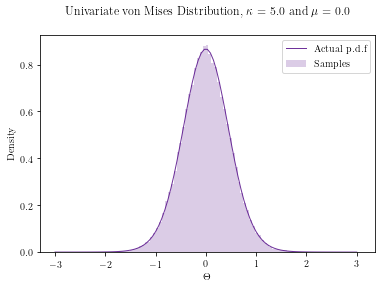

In [3]:
#Actual p.d.f vs. samples
rng_key = random.PRNGKey(190)
testvm = VonMises(0, 5)
samples = testvm.sample(rng_key, 100000)

fig, ax = plt.subplots(1, 1)
kappa = 5
mean, var, skew, kurt = vonmises.stats(kappa, moments='mvsk')
x = np.linspace(-3, 3, 100)
ax.plot(x, vonmises.pdf(x, kappa),'indigo', lw=1, alpha= 0.8, label='Actual p.d.f')
ax.hist(samples, 100, density=True, color = "indigo",histtype='stepfilled', alpha=0.2, label = "Samples")
plt.title("Univariate von Mises Distribution, $\kappa$ = 5.0 and $\mu$ = 0.0")
plt.legend()
plt.xlabel("$\Theta$")
plt.ylabel("Density")
plt.savefig("von_mises_results", dpi = 500, bbox_inches = 'tight')

## Bivariate Von Mises – sampling & logCinv 

In [4]:
@partial(jit, static_argnums = (0,1,))
def _acg_bound(sample, k1, k2, alpha, key):
    lam = np.concatenate((np.zeros([len(k1), 1]), 0.5*(k1 - alpha**2/k2).reshape(len(k1), 1)), axis = 1)
    lambda_min = np.min(lam, axis = 1).reshape([len(k1), 1])
    lam = lam - lambda_min
    b_values = np.concatenate((np.array(np.sqrt(lam[:,1]**2 + 1) - lam[:,1]
                                        + 1).reshape([len(k1), 1]), np.ones([len(k1),1])*2), axis = 1)
    b0 = np.min(b_values, axis = 1).reshape([len(k1), 1])

    phi = 1 + 2*lam/b0
    den = _log_modified_bessel_fn(k2, 0)
    
    accept_shape = sample.shape[:len(sample.shape)-1] + (1,)
    accept = np.zeros(accept_shape, dtype = "bool_")
    count = 0
    args = (key, phi, k1, k2, lam, lambda_min, sample, accept, den, b0, alpha)
    res = lax.while_loop(loop_condition, loop_acg, args)[6]
    
    return np.arctan2(res[...,1], res[...,0])

def loop_acg(args):
    key, phi, k1, k2, lam, lambda_min, sample, accept, den, b0, alpha = args
    key, subkey = jax.random.split(key)
    x = np.where(accept, 0,  jax.random.normal(subkey, sample.shape)*np.sqrt(1/phi))    
    r = np.sqrt(np.sum(x**2, axis = -1))        
    r = np.expand_dims(r, axis=-1)
    x = x/r
    u = (x**2 * lam).sum(-1)
    v = jax.random.uniform(subkey, (sample.shape[0], k1.shape[0]))

    logf = k1*(x[...,0] - 1) + lambda_min.T + _log_modified_bessel_fn(np.sqrt(k2**2 + alpha**2 * x[...,1]**2), 0) - den           
    loggi = 0.5 * (2 - b0.T) + np.log(1 + 2*u/b0.T) + np.log(b0.T/2)
    logfg = np.add(logf, loggi)
    logfg = logfg.reshape([sample.shape[0], k1.shape[0]])
    
    accept = v < np.exp(logfg)
    accept = accept[..., None]
    sample = np.where(accept, x,  sample)

    return (key, phi, k1, k2, lam, lambda_min, sample, accept, den, b0, alpha)

def loop_condition(args):
    return np.count_nonzero(np.isnan(args[6])) > 0

@partial(jit, static_argnums = (1,))
def log_im(order, k): 
    """ x is a parameter, like k1 or k2
        Tanabe, A., Fukumizu, K., Oba, S., Takenouchi, T., & Ishii, S. (2007). 
        Parameter estimation for von Mises–Fisher distributions. Computational Statistics, 22(1), 145-157. 
        
        The implementation is based on Christian Breinholt's Pytorch implementation.
    """
    k = k.reshape([len(k), 1, 1])   
    s = np.arange(0 , 251).reshape(251, 1)  
    fs = 2 * s * np.log(k/2) - gammaln(s + 1) - gammaln(order + s + 1)
    f_max = np.max(fs, axis = -2)
    k = k.reshape([len(k), 1])   
   
    return (order * np.log(k/2) + f_max + logsumexp(fs - f_max[:,None], -2)).squeeze()


@partial(jit, static_argnums = (0,))
def log_C(k1, k2, lam):
    
    """Harshinder Singh, Vladimir Hnizdo, and Eugene Demchuk
    Probabilistic model for twodependent circular variables.
    Biometrika, 89(3):719–723, 2002.

    Closed form expression of the normalizing constant
    Vectorized and in log-space
    
    k1, k2 & lam are the parameters from the bivariate von Mises
    
    Since the closed expression is an infinite sum, 'terms' is the number
    of terms, over which the expression is summed over. Estimation by convergence. 
    
    The code is translated to Numpyro from Christian Breinholt's Pytorch implementation."""
    
    terms = 51
    lam = np.abs(lam) + 1e-12
    m = np.arange(0, terms)    
    log_binom = gammaln(2*m+1) - 2*gammaln(m+1) 
    
    logC = log_binom*np.ones((len(k1), terms)) + m*np.log((lam**2)/(4*k1*k2))[:,None] + log_im(m, k1) + log_im(m, k2)
    
    return - np.log(4*np.pi**2) - logsumexp(logC, axis = -1)

@copy_docs_from(Distribution)
class BivariateVonMises(Distribution):
    """
    Bivariate von Mises (Sine Model) distribution on the torus
    
    The distribution should be only used for unimodal cases. A warning message is printed if the distribution
    is bimodal. The distribtion is the bimodal if lam**2 > k1*k2.
    
    :param numpy.ndarray mu, nu: an angle in radians
    :param numpy.ndarray k1, k2 > 0: concentration parameters
    :param numpy.ndarray lam: correlation parameter
    :param numpy.ndarray w: reparameterization parameter – within range [-1, 1]
    """
    arg_constraints = {'mu':  constraints.real, 
                       'nu':  constraints.real,
                       'k1':  constraints.positive, 
                       'k2':  constraints.positive, 
                       'lam': constraints.real}
    support = constraints.real
    has_rsample = False
    
    def __repr__(self):
        param = self.lam
        printing = ", lam: "
        if self.lam is None:
            param = self.w
            printing = ", w: "
        return str(type(self).__name__) + "(mu: " + str(self.mu) + ", nu: " + str(self.nu) + ", k1: " + str(self.k1) + ", k2: " + str(self.k2) + printing + str(param) + ")"

    def __init__(self, mu, nu, k1, k2, lam = None, w = None, validate_args = None):
        
        if lam is None == w is None:
            raise ValueError("Either `lam` or `w` must be specified, but not both.")
        elif w is None:
            self.mu, self.nu, self.k1, self.k2, self.lam = promote_shapes(mu, nu, k1, k2, lam)

        elif lam is None:
            self.mu, self.nu, self.k1, self.k2, self.w = promote_shapes(mu, nu, k1, k2, w)
            self.lam = np.sqrt(self.k1*self.k2) * self.w
       
        if not np.all(self.lam**2 <= self.k1*self.k2):
             warnings.warn("The joint density is bimodal. The sampling method is not optimal for bimodal distributions.")

        batch_shape = lax.broadcast_shapes(np.shape(self.mu), 
                                           np.shape(self.nu),
                                           np.shape(self.k1),
                                           np.shape(self.k2),
                                           np.shape(self.lam))
        event_shape = (2,)
        
        self.logC = log_C(self.k1, self.k2, self.lam)
            
        super(BivariateVonMises, self).__init__(batch_shape, event_shape, validate_args)
    
    def sample(self, key, sample_shape = ()):
        """ Harshinder Singh, Vladimir Hnizdo, and Eugene Demchuk
            Probabilistic model for twodependent circular variables.
            Biometrika, 89(3):719–723, 2002.
            
        The sampling from marginal distribution is done using acceptance-rejection sampling with angular central
        Gaussian (ACG) distribution as the envelope distribution. The sampling from conditional distribution is done
        using acceptance-rejection sampling using wrapped Cauchy distribution as the envelope distribution with 
        parameters (nu + arctan((lam/k2) * sin(marg - mu))) where marg is the sampled angle from marginal distribution.
        cond: conditional distribution using a modified univariate von Mises (as described in Singh et al. (2002))
        
        The sampling method follows Christian Breinholt's Pytorch implementation. 
        """
        if sample_shape == 1: sample_shape = ()
        if isinstance(sample_shape, int):
            shape = tuple([sample_shape]) + self.batch_shape + self.event_shape
        elif sample_shape == ():
            shape = (1,) + self.batch_shape + self.event_shape    
        else: 
            shape = sample_shape + self.batch_shape + self.event_shape

        x = np.empty(shape)*np.nan

        marg = _acg_bound(x, self.k1, self.k2, self.lam, key)                 #Sampling from marginal distribution
        marg = (marg + self.mu + np.pi) % (2 * np.pi) - np.pi 
        marg = np.squeeze(marg)
        
        alpha = np.sqrt(self.k2**2 + self.lam**2 * np.sin(marg - self.mu)**2) #Sampling from conditional distribution
        beta  = np.arctan(self.lam / self.k2 * np.sin(marg - self.mu))
        cond  = VonMises(self.nu + beta, alpha).sample(key)
          
        if len(self.k1) == 1 and sample_shape == ():
            marg = np.array([marg])
        
        return np.array([marg, cond]).T
    
    def expand(self, batch_shape):
        validate_args = self.__dict__.get('_validate_args')
        mu = np.ones(batch_shape)*self.mu
        nu = np.ones(batch_shape)*self.nu
        k1 = np.ones(batch_shape)*self.k1
        k2 = np.ones(batch_shape)*self.k2

        if self.lam is not None:
            lam = np.ones(batch_shape)*self.lam
            w = None
        else:
            w = np.ones(batch_shape)*self.w
            lam = None
        
        return BivariateVonMises(mu, nu, k1, k2, lam = lam, w = w, validate_args=validate_args)
    
    @validate_sample
    def log_prob(self, angles):
        """ Actual likelihood function, log joint distribution of phi and psi.
        The code was translated from Christian Breinholt's Pytorch implementation"""
            
        phi = angles[...,0]
        psi = angles[...,1]

        log_prob = self.k1*np.cos(phi - self.mu) + self.k2*np.cos(psi - self.nu)
        log_prob += self.lam*np.sin(phi - self.mu)*np.sin(psi - self.nu)
        log_prob += self.logC
        return log_prob

In [5]:
def Ramachandran_plot(data_angles, c, fname = None, title = None):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    degrees = np.rad2deg(data_angles) 
    phi = degrees[:,0] 
    psi = degrees[:,1] 
    plt.figure(figsize=(7, 6))
    plt.hist2d(phi, psi, bins = 200, norm = LogNorm(), cmap = plt.cm.viridis )
    plt.title(title) 
    plt.xlabel('$\psi$')
    plt.ylabel('$\phi$')    
    plt.xlim(-c, c)
    plt.ylim(-c, c)
    plt.colorbar()
    if title is not None and fname is not None:
        plt.savefig(fname, dpi = 500, bbox_inches = 'tight')
    else:
        plt.show()
        
from matplotlib import rc
import matplotlib.pyplot as plt

## Initialising multiple distributions at once

In [6]:
mu_np = np.array([0., 0.2, 1.0, 0])
nu_np = np.array([0., 0.2, 1.0, 0])
k1_np = np.array([1., 70., 1, 70])
k2_np = np.array([1., 60., 1, 70])
lam_np = np.array([1., 15., 1, 6])

n = 100000
rng_key = random.PRNGKey(190)
bvms_b = BivariateVonMises(mu = mu_np, nu = nu_np, k1 = k1_np, k2 = k2_np, lam = lam_np)
angles_parallel = bvms_b.sample(rng_key, n)
angles_parallel

start = time.time()
angles = bvms_b.sample(rng_key)
end = time.time()
print("Sampling took", end-start, "seconds for", n , "samples.")

Sampling took 1.8599588871002197 seconds for 100000 samples.


## Sampling angle pairs from the distribution for plotting 

Sampling took  6.280472040176392  seconds for  1000000  samples.


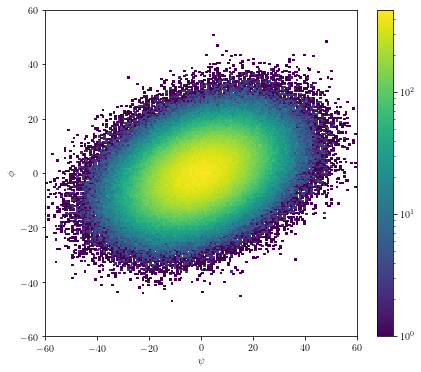

In [7]:
mu = np.array([0])
nu = np.array([0])
k1 = np.array([20])
k2 = np.array([40])
lam = np.array([10])
bvms_a = BivariateVonMises(mu = mu, nu = nu, k1 = k1, k2 = k2, lam = lam)
rng_key = random.PRNGKey(190)

n = 1000000
start = time.time()
angles1 = bvms_a.sample(rng_key, n)
end = time.time()

print("Sampling took ", end-start, " seconds for ", n , " samples.")
Ramachandran_plot(angles1, 60, fname = "20_40_10.png", title = "")

Sampling took  6.019184112548828  seconds for  1000000  samples.


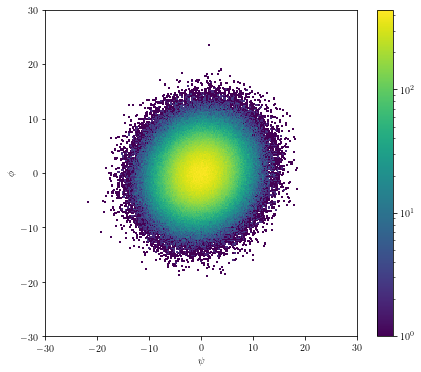

In [8]:
mu = np.array([0])
nu = np.array([0])
k1 = np.array([200])
k2 = np.array([200])
lam = np.array([20])
bvms_a = BivariateVonMises(mu = mu, nu = nu, k1 = k1, k2 = k2, lam = lam)
rng_key = random.PRNGKey(190)

n = 1000000
start = time.time()
angles2 = bvms_a.sample(rng_key, n)
end = time.time()

print("Sampling took ", end-start, " seconds for ", n , " samples.")
Ramachandran_plot(angles2, 30, fname = "200_200_20.png", title = "")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:129: UserWarning: The joint density is bimodal. The sampling method is not optimal for bimodal distributions.


Sampling took  29.030779123306274  seconds for  1000000  samples.


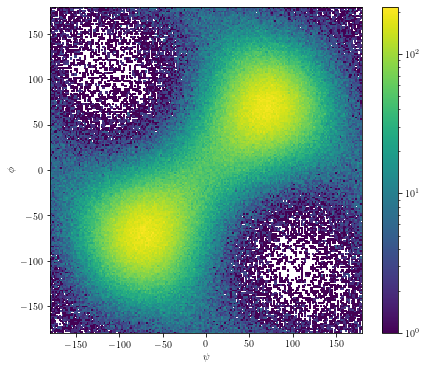

In [9]:
mu = np.array([0])
nu = np.array([0])
k1 = np.array([1])
k2 = np.array([1])
lam = np.array([3])
bvms_a = BivariateVonMises(mu = mu, nu = nu, k1 = k1, k2 = k2, lam = lam)
rng_key = random.PRNGKey(190)

n = 1000000
start = time.time()
angles3 = bvms_a.sample(rng_key, n)
end = time.time()

print("Sampling took ", end-start, " seconds for ", n , " samples.")
Ramachandran_plot(angles3, 180, fname = "1_1_3.png", title = "")